In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wERdgvFXZw4H04aa0aaYE4OVwX0DUKVCJdeGvofRILTsdCXvejHYiM
Mounted at /content/drive


In [ ]:
PATH = '/content/'
FILE = f'{PATH}data_augmented_post_stopword.xlsx'

X0 = 'Final Data'
X1 = 'Short description'
X2 = 'Description'
X3 = 'Caller'
Y = 'Assignment group'
TARGET = 'target'

X4 = 'Word Count'
X5 = 'Short Word Count'

MODEL = 'ats.3k.100d.model'

SEED = 1

In [ ]:
data = pd.read_excel(FILE, engine='openpyxl')
data = data[data[X0].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10780 entries, 0 to 10786
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  10773 non-null  object
 1   Description        10720 non-null  object
 2   Caller             10780 non-null  object
 3   Assignment group   10780 non-null  object
 4   Final Data         10780 non-null  object
 5   Word Count         10780 non-null  int64 
 6   Short Word Count   10780 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 673.8+ KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Word Count,10780.0,20.166790,45.199085,1.0,6.0,11.0,22.0,1062.0
Short Word Count,10780.0,5.059555,2.641062,1.0,3.0,5.0,6.0,19.0
target,10780.0,23.531818,25.484026,0.0,0.0,12.0,46.0,73.0


In [ ]:
text = [[text for text in doc.split()] for doc in data[X0].astype(str)]

In [ ]:
words = {}
for sentence in text:
  for word in sentence:
    if word in words:
      words[word] = words[word] + 1
    else:
      words[word] = 1

In [ ]:
words_df = pd.DataFrame(list(words.items()),columns = ['word','count'])

In [ ]:
words_df.describe().T

,count,mean,std,min,25%,50%,75%,max
count,11820.0,18.385364,93.0837,1.0,1.0,2.0,6.0,2969.0


In [ ]:
total_low_words_sentence = 0
for sentence in text:
  def check_low_word_count(sentence):
    for word in sentence:
      if words[word] >= 5:
        return False
    return True
  if check_low_word_count(sentence):
    print(sentence)
    total_low_words_sentence = total_low_words_sentence + 1

total_low_words_sentence

['dds', 'dss']


1

We have only 1 such sentences which has words with frequencies less than 5. Noticeable thing is that out of 11k words it has pruned down to just 3k words

In [ ]:
VECTOR_SIZE = 100
model = Word2Vec(text, sg=1, size=VECTOR_SIZE)

In [ ]:
len(model.wv.vectors)

3378

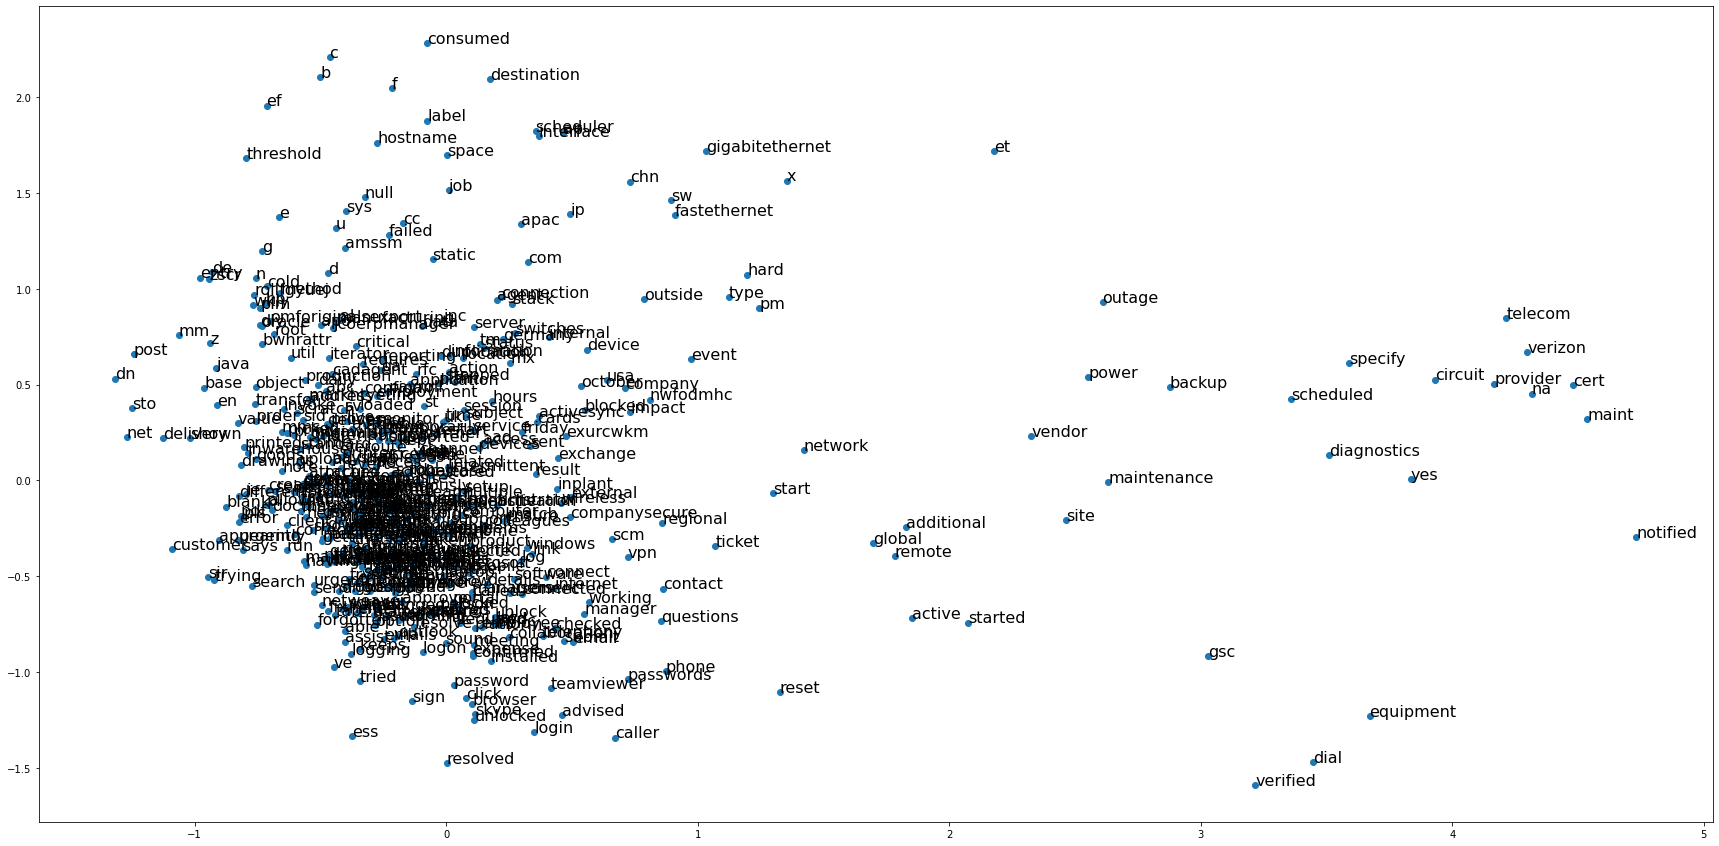

In [ ]:
def show_word_scatter(model, plot_limit):
    pca = PCA(n_components=2)
    result = pca.fit_transform(model.wv[model.wv.vocab][:plot_limit])

    size = (30,15)
    fig, ax = plt.subplots(figsize=size)

    ax = plt.scatter(result[:, 0], result[:, 1])

    words = list(model.wv.vocab)[:plot_limit]
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=16)
    plt.show()

PLOT_LIMIT = 500
show_word_scatter(model, PLOT_LIMIT)

In [ ]:
model.save(MODEL)
ats_model = Word2Vec.load(MODEL)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
labelEncoder = LabelEncoder()
data[TARGET] = labelEncoder.fit_transform(list(data[Y]))
CLASS = list(data[TARGET])

In [ ]:
max_features = 10000
maxlen = 100
embedding_size = VECTOR_SIZE

UNKNOWN = "<unknown>"
PADDING = "<padding>"

def tokenize(sentences, max_feat):
  tokenizer = Tokenizer(num_words=max_feat, lower=True, oov_token=UNKNOWN)
  tokenizer.fit_on_texts(sentences)
  tokenizer.word_index[PADDING] = 0
  tokenizer.index_word[0] = PADDING

  sequences = tokenizer.texts_to_sequences(sentences)
  maxlen = max([len(x) for x in sequences])
  return tokenizer, sequences, maxlen

def pad_sentences(sentences, maxlen):
  return pad_sequences(sentences, maxlen=maxlen, padding='post').tolist()

def reshape_sentences(sentences, maxlen):
  return sentences.reshape(len(sentences), maxlen, 1)

In [ ]:
tokenizer, sequences, maxlen = tokenize(data[X0].astype(str), max_features)
X = pad_sentences(sequences, maxlen)

print("\nPadded sequences:\n", X[10])
print("Sequences data type:", type(sequences))
print("Padded sequences data type:", type(X))

X = np.asarray(X)
X = reshape_sentences(X, maxlen)
print(type(X))
print(X.shape)

num_words = len(tokenizer.word_index) + 1
print(num_words)


Padded sequences:
 [53, 6, 508, 291, 18, 277, 328, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
ats_model.wv[53]

TypeError: ignored

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, CLASS, stratify=CLASS, test_size=0.15, random_state=SEED)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
